In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


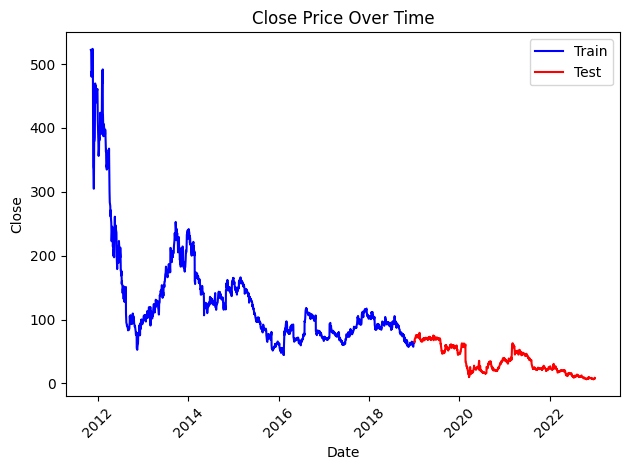

In [2]:
#AAPL
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
data = Data('GRPN',start_date,end_date,2019)
data.data_preprocess()

In [3]:
ga = IslandGGA(data=data.train_data,K=5,num_islands=8,m_iter= 10,num_iter=20,n_migrants_rate=0.8,pSize=30,r_cross=0.3,r_mut=0.1,strategies=data.strategies,evolve_strategy="ring")
ga.evolve()

Running ring
GENERATION 0 START
Generation 0: Best fitness = 3.987127433520701 Average Fitness = 3.171034497954264
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 3.987127433520701 Average Fitness = 3.371132818995
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 4.063155633457588 Average Fitness = 3.551038609845888
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 4.325620223086375 Average Fitness = 3.6266040049427524
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 4.337810095910822 Average Fitness = 3.7712650543735804
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 4.367552756310649 Average Fitness = 3.7980529380986696
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 4.367552756310649 Average Fitness = 3.7786541783604606
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 4.367552756310649 Average Fitness = 3.824863708975264
GENERATION 7 END
GENERATION 8 START
Generation 8: B

In [10]:
b= ga.globalBest
ts_data = b.strategy_performance(data.train_data)
weights = b.getWeights()
print(f"weights: {weights}")
total = 0
ts_mdd = {}
for i in range(len(b.group_part)):
    tsp_mins = []
    print(f"group {i+1}")
    for j in b.group_part[i]:
        # Calculate the cumulative returns for each asset at the end of each month
        cumulative_returns = (1+ ts_data[j]).cumprod()
        # Calculate the cumulative maximum value for each asset at the end of each month
        cumulative_max = cumulative_returns.cummax()
        # Calculate the drawdown for each asset at the end of each month
        drawdown = cumulative_max - cumulative_returns
        # Calculate the maximum drawdown for each asset
        max_drawdown = drawdown.max()
        print(f"{j}: mdd {max_drawdown}")
        ts_mdd[j] = max_drawdown
        tsp_mins.append(max_drawdown)
    print(f"GROUP mdd: {max(tsp_mins)}")
    if tsp_mins:
        total+= max(tsp_mins)
mdd = total/len(b.group_part)
print(mdd)

weights: {0: 0.11, 1: 0.11, 2: 0.78, 3: 0.0, 4: 0.0, 5: 0.0}
group 1
TS16: mdd 0.6434615653017253
TS19: mdd 0.31059961497465005
TS8: mdd 0.7825919501295056
TS15: mdd 0.7957779671914677
GROUP mdd: 0.7957779671914677
group 2
TS2: mdd 0.7365076506029931
TS3: mdd 0.6338543927273761
TS4: mdd 0.6876296925977042
TS13: mdd 0.6649880318058917
GROUP mdd: 0.7365076506029931
group 3
TS18: mdd 0.49915518574035866
TS17: mdd 0.6142954792874469
TS9: mdd 0.6418012470167354
TS10: mdd 0.5296601680908044
GROUP mdd: 0.6418012470167354
group 4
TS20: mdd 0.7760029364765351
TS6: mdd 0.7082652252373552
TS12: mdd 0.795991502398042
TS7: mdd 0.7233736013267758
GROUP mdd: 0.795991502398042
group 5
TS14: mdd 0.7889529271585662
TS5: mdd 0.7825919501295056
TS1: mdd 0.7687827269074646
TS11: mdd 0.5788834193918768
GROUP mdd: 0.7889529271585662
0.7518062588735608


In [118]:
asset_prices = data.train_data.copy()
# Set the 'Date' column as the index of the DataFrame if it's not already
asset_prices.set_index('Date', inplace=True)

# Resample the asset prices to monthly frequency and select the first and last values of each month
monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

# Calculate the monthly returns as the percentage change in price
monthly_returns = monthly_prices['close', 'last'].pct_change()

# Calculate the cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod()

# Calculate the profit as the difference between the final cumulative return and 1 (initial investment)
profit = cumulative_returns.iloc[-1]-1

print("Profit for the Buy-and-Hold Strategy:")
print(profit)
print("Profit for the gtspo Strategy:")
print(ga.globalBest.mdd)

Profit for the Buy-and-Hold Strategy:
-0.8171428571428571
Profit for the gtspo Strategy:
0.352972240763728


In [115]:
import pandas as pd

def getProfit(self, ts_data, allocated_capital):
    weights = self.getWeights()
    total = 0
    normalised_total = 0
    
    # Calculate profits for each trading strategy
    ts_profits = (1 + ts_data).cumprod().iloc[-1] - 1
    
    for i, group in enumerate(self.group_part):
        if weights[i+1] != 0:
            group_profits = ts_profits[group]
            
            # Calculate contributions for the original values
            contribution = group_profits * weights[i+1] * allocated_capital
            total += contribution.mean()
            
            # Normalize profits and calculate contributions
            series = pd.Series(group_profits)

            # Perform min-max normalization
            
            normalized_profits = (series - series.min()) / (series.max() - series.min())
            normalized_contribution = normalized_profits * weights[i+1] * allocated_capital
            normalised_total += normalized_contribution.mean()
    
    return total, normalised_total
getProfit(b,ts_data,1)

(1.420474115855805, 0.22985017357699192)

In [95]:
asset_prices = data.train_data.copy()
# Set the 'Date' column as the index of the DataFrame if it's not already
asset_prices.set_index('Date', inplace=True)

# Resample the asset prices to monthly frequency and select the first and last values of each month
monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

# Calculate the monthly returns as the percentage change in price
monthly_returns = monthly_prices['close', 'last'].pct_change()


 #Calculate the cumulative returns for each asset at the end of each month
cumulative_returns = (1+ monthly_returns).cumprod()
# Calculate the cumulative maximum value for each asset at the end of each month
cumulative_max = cumulative_returns.cummax()
# Calculate the drawdown for each asset at the end of each month
drawdown = cumulative_max - cumulative_returns
# Calculate the maximum drawdown for each asset
max_drawdown = drawdown.max()


# Print the result
print("Maximum Drawdown: {:.2f}".format(max_drawdown))


Maximum Drawdown: 1.02


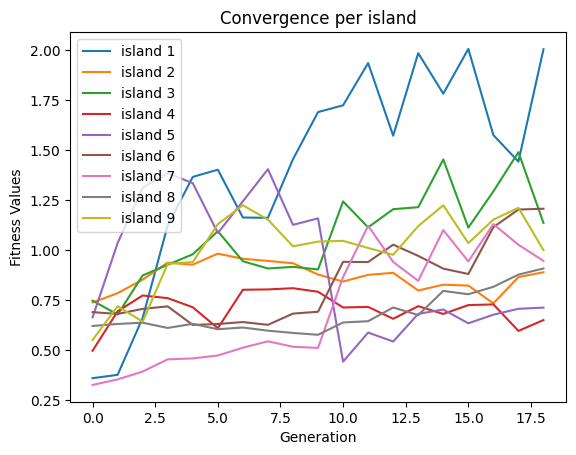

In [96]:
#plot
x = range(len(ga.island_convergence[:-1]))
y = [[island[i] for island in ga.island_convergence[:-1]] for i in range(len(ga.island_convergence[0][:-1]))]
# Define the labels for each data column
labels = [f'island {i+1}' for i in range(len(y))]

# Plot the data dynamically using a loop
for i, column in enumerate(y):
    plt.plot(x, column, label=labels[i])
plt.xlabel('Generation')
plt.ylabel('Fitness Values')
plt.title('Convergence per island')
plt.legend()
plt.show()